In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import os
import random
import shutil
import glob
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [20, 12]

### Metadatas

In [2]:
METADATA_PATH = 'data/project-1-at-2022-10-20-09-37-9a7c9b50.json'
ANNOTAION_TO_FILENAME = {
    3: 'video_3.mp4',
    4: 'video_4.mp4',
    5: 'video_2.mp4',
    6: 'video_1.mp4',
}
STOPPED_SECTIONS = {
    4: [(0, 400)],
    6: [(0, 8000)]
}
VIDEO_FOLDER_PATH = 'videos/'
IMAGES_FOLDER_PATH = 'images/'

In [3]:
with open(METADATA_PATH) as f:
    data = json.load(f)

### Read in all of the keyframe sequence label metadatas

In [4]:
video_keyframe_sequences = dict()
frame_counts = dict()

for annotation in data:
    if annotation['id'] in ANNOTAION_TO_FILENAME:
        print(f"Processing {ANNOTAION_TO_FILENAME[annotation['id']]} ({annotation['id']})")
        
        labels = annotation['annotations'][0]['result']
        keyframe_sequences = list()
        
        for label_index, label in enumerate(labels):
            label_type = label['value']['labels'][0]
            frame_counts[annotation['id']] = label['value']['framesCount']
            
            sub_sequence = list()
            is_enabled = False
            
            for frame in label['value']['sequence']:
                frame['label_type'] = label_type
                frame['label_index'] = label_index
                
                if frame['frame'] > 0:
                    frame['frame'] = frame['frame'] - 1
                
                if frame['enabled'] == True:
                    is_enabled = True
                    sub_sequence.append(frame)
                elif frame['enabled'] == False and is_enabled:
                    sub_sequence.append(frame)
                    keyframe_sequences.append(sub_sequence)
                    sub_sequence = list()
            
            if len(sub_sequence) > 0:  
                keyframe_sequences.append(sub_sequence)
        
        video_keyframe_sequences[annotation['id']] = keyframe_sequences

Processing video_4.mp4 (4)
Processing video_3.mp4 (3)
Processing video_1.mp4 (6)
Processing video_2.mp4 (5)


In [5]:
video_frames = dict()

for annotation_id, keyframe_sequences in video_keyframe_sequences.items():
    print(f'Processing {ANNOTAION_TO_FILENAME[annotation_id]} ({annotation_id})')
    frames = dict()

    for i in range(frame_counts[annotation_id]):
        labels = list()
        
        for keyframe_sequence in keyframe_sequences:
            first_frame = keyframe_sequence[0]
            last_frame = keyframe_sequence[-1]
            
            if first_frame['frame'] <= i and i <= last_frame['frame']:
                keyframe = list(filter(lambda frame: frame['frame'] == i, keyframe_sequence))
                if len(keyframe) > 0:
                    frame = {
                        'label_type': keyframe[0]['label_type'],
                        'x': keyframe[0]['x'],
                        'y': keyframe[0]['y'],
                        'width': keyframe[0]['width'],
                        'height': keyframe[0]['height'],
                        'keyframe': True
                    }
                    
                    labels.append(frame)
                    continue
                
                keyframe_before = list(filter(lambda frame: frame['frame'] < i, keyframe_sequence))[-1]
                keyframe_after = list(filter(lambda frame: frame['frame'] > i, keyframe_sequence))[0]
                
                multiplier = (i - keyframe_before['frame']) / (keyframe_after['frame'] - keyframe_before['frame'])
                
                frame = {
                    'label_type': keyframe_before['label_type'],
                    'x': keyframe_before['x'] + (keyframe_after['x'] - keyframe_before['x']) * multiplier,
                    'y': keyframe_before['y'] + (keyframe_after['y'] - keyframe_before['y']) * multiplier,
                    'width': keyframe_before['width'] + (keyframe_after['width'] - keyframe_before['width']) * multiplier,
                    'height': keyframe_before['height'] + (keyframe_after['height'] - keyframe_before['height']) * multiplier,
                    'keyframe': False
                }
                
                labels.append(frame)
        
        if len(labels) > 0:
            frames[i] = labels
            
    video_frames[annotation_id] = frames
            

Processing video_4.mp4 (4)
Processing video_3.mp4 (3)
Processing video_1.mp4 (6)
Processing video_2.mp4 (5)


Processing "videos/video_4.mp4"


[ WARN:0@292.418] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@292.418] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@292.418] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@292.418] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_

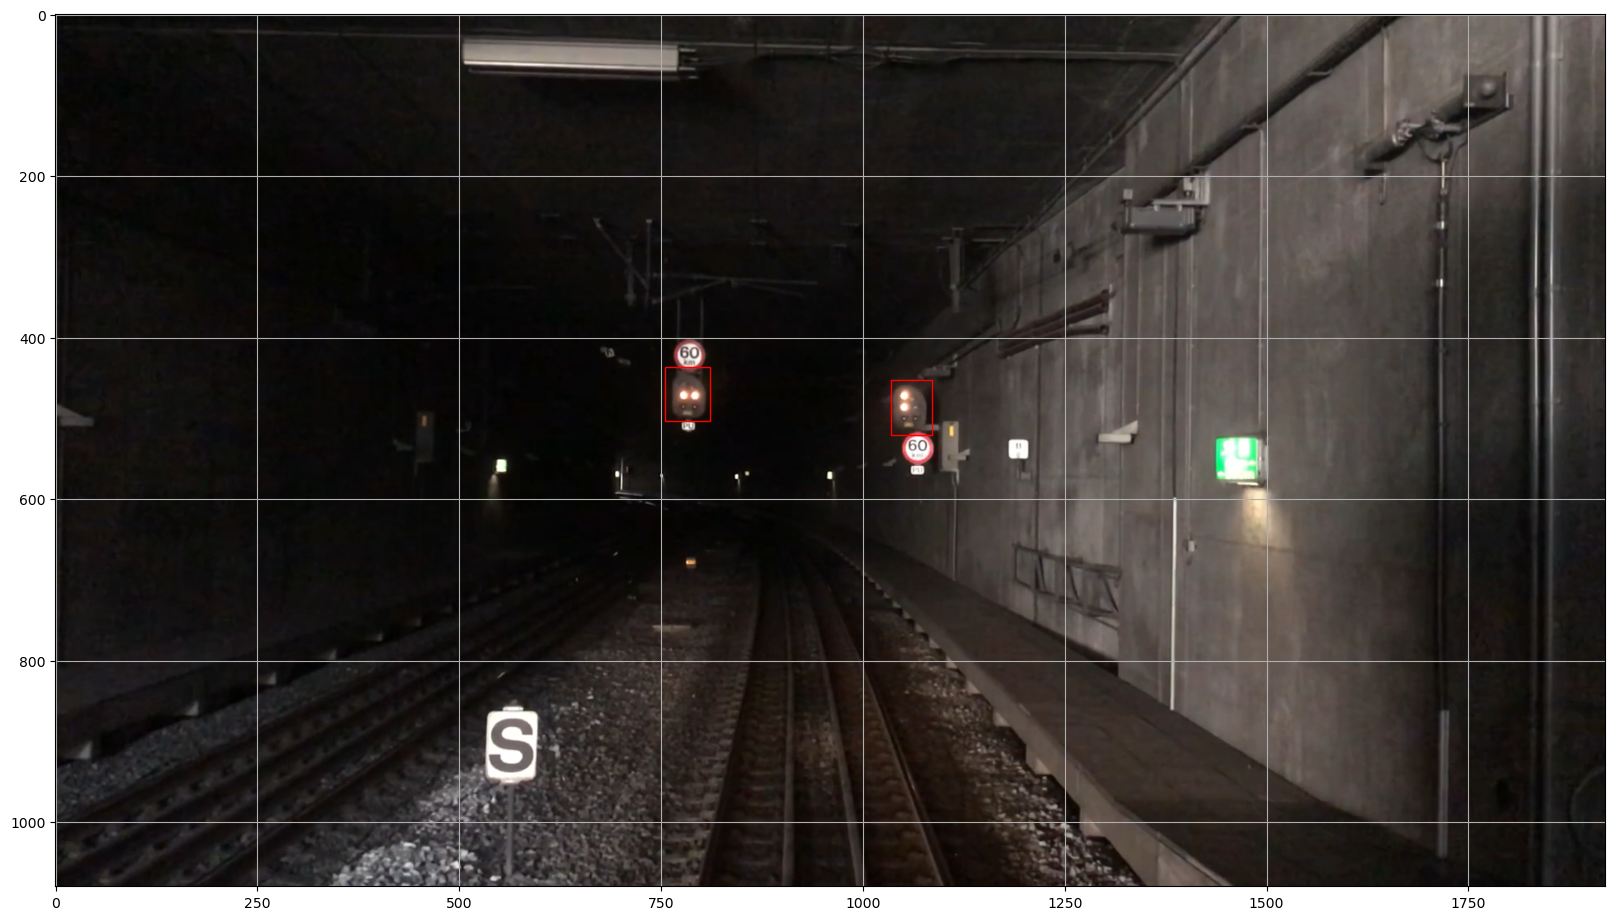

In [10]:
FRAME_ID = 100
ANNOTAION_ID = 4
PADDING = 0.05

labels = video_frames[ANNOTAION_ID][FRAME_ID]

file_path = os.path.join(VIDEO_FOLDER_PATH, ANNOTAION_TO_FILENAME[ANNOTAION_ID])
print(f'Processing "{file_path}"')

cap = cv2.VideoCapture(file_path)

original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_ID+2)

ret, frame = cap.read()

for i, label in enumerate(labels):
    pixel_x = int(label['x'] / 100.0 * original_width)
    pixel_y = int(label['y'] / 100.0 * original_height)
    pixel_width = int(label['width'] / 100.0 * original_width)
    pixel_height = int(label['height'] / 100.0 * original_height)
    
    pixel_x = pixel_x - int(pixel_width * PADDING)
    pixel_y = pixel_y - int(pixel_height * PADDING)
    pixel_width = pixel_width + int(pixel_width * PADDING * 2)
    pixel_height = pixel_height + int(pixel_height * PADDING * 2)
    
    crop_img = frame[pixel_y:pixel_y+pixel_height, pixel_x:pixel_x+pixel_width]
    cv2.imwrite(os.path.join('images_2', f'image_{i}.jpg'), crop_img)
    
    rect = patches.Rectangle((pixel_x, pixel_y), pixel_width, pixel_height, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.grid()

### Extract frame labels from keyframe sequences

In [13]:
MOVE_SAMPLE_RATIO = 0.2
STOP_SAMPLE_COUNT = 5

video_frame_list = dict()

for annotation_id, frames in video_frames.items():
    print(
        f'Processing {ANNOTAION_TO_FILENAME[annotation_id]} ({annotation_id})')

    frame_list = np.array(list(frames.keys()))

    if annotation_id in STOPPED_SECTIONS:
        stop_list = list()
        for sections in STOPPED_SECTIONS[annotation_id]:
            stop_list += list(range(sections[0], sections[1], 1))
        stop_list = np.array(stop_list)
        move_list = frame_list[~np.isin(frame_list, stop_list)]
        
        stop_selected_frame_list = np.random.choice(stop_list, STOP_SAMPLE_COUNT, replace=False)
        move_selected_frame_list = np.random.choice(move_list, int(len(move_list) * MOVE_SAMPLE_RATIO), replace=False)
        
        selected_frame_list = np.concatenate((stop_selected_frame_list, move_selected_frame_list))
    else:
        selected_frame_list = np.random.choice(frame_list, int(len(frame_list) * MOVE_SAMPLE_RATIO))

    selected_frame_list = list(sorted(selected_frame_list))
    print(f'Found {len(selected_frame_list)} frames')

    video_frame_list[annotation_id] = selected_frame_list


Processing video_4.mp4 (4)
Found 339 frames
Processing video_3.mp4 (3)
Found 578 frames
Processing video_1.mp4 (6)
Found 380 frames
Processing video_2.mp4 (5)
Found 1073 frames


In [7]:
frame_counts

{4: 7828, 3: 8129, 6: 45217, 5: 35607}

### Crop out all of the bounding boxes

In [14]:
MIN_SIZE_X = 40
MIN_SIZE_Y = 50
SIZE_X = 60
SIZE_Y = 80
PADDING = 0.05

# A dangerous function, but it's ok for this case
shutil.rmtree(IMAGES_FOLDER_PATH, ignore_errors=True)

# Create images folder
os.makedirs(IMAGES_FOLDER_PATH, exist_ok=True)

for annotation_id, frame_list in video_frame_list.items():
    print(f'Processing {ANNOTAION_TO_FILENAME[annotation_id]} ({annotation_id})')
    file_path = os.path.join(VIDEO_FOLDER_PATH, ANNOTAION_TO_FILENAME[annotation_id])
    
    frames = video_frames[annotation_id]
    
    cap = cv2.VideoCapture(file_path)
    
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    frame_id = -1
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret == False:
            break
        
        if frame_id in frame_list:
            labels = frames[frame_id]
            
            for i, label in enumerate(labels):
                label_type = label['label_type']
                
                pixel_x = int(label['x'] / 100.0 * original_width)
                pixel_y = int(label['y'] / 100.0 * original_height)
                pixel_width = int(label['width'] / 100.0 * original_width)
                pixel_height = int(label['height'] / 100.0 * original_height)
                
                pixel_x = pixel_x - int(pixel_width * PADDING)
                pixel_y = pixel_y - int(pixel_height * PADDING)
                pixel_width = pixel_width + int(pixel_width * PADDING * 2)
                pixel_height = pixel_height + int(pixel_height * PADDING * 2)
                
                crop_img = frame[pixel_y:pixel_y+pixel_height, pixel_x:pixel_x+pixel_width]
                
                if MIN_SIZE_X <= crop_img.shape[1] and MIN_SIZE_Y <= crop_img.shape[0]:
                    crop_img = cv2.resize(crop_img, (SIZE_X, SIZE_Y))
                    cv2.imwrite(os.path.join(IMAGES_FOLDER_PATH, f'{label_type}---{annotation_id}_{frame_id}_{i}.jpg'), crop_img)
        
        frame_id += 1

Processing video_4.mp4 (4)


[ WARN:0@449.944] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@449.944] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin8 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@449.944] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@449.944] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_

Processing video_3.mp4 (3)


[ WARN:0@462.985] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@462.986] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin9 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@462.986] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@462.986] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_

Processing video_1.mp4 (6)


[ WARN:0@476.825] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@476.825] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin10 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@476.825] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@476.825] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite

Processing video_2.mp4 (5)


[ WARN:0@486.266] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@486.266] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin11 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@486.266] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@486.266] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite

## Generate YOLO dataset

In [8]:
def get_label_id(label):
    if '1_AND_2' in label:
        return 0
    if '1_AND_4' in label:
        return 1
    if '1_AND_3' in label:
        return 2
    if '2_AND_4' in label:
        return 3
    
    return 4

In [15]:
YOLO_DATASET_PATH = 'yolo/'
LABELS = ['1_AND_2', '1_AND_4', '1_AND_3', '2_AND_4', 'OTHER']
SIZE_X = 60
SIZE_Y = 80
PADDING = 0.05

# A dangerous function, but it's ok for this case
shutil.rmtree(YOLO_DATASET_PATH, ignore_errors=True)

# Create folder system
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'labels', 'train'), exist_ok=True)

# Create train.txt
with open(os.path.join(YOLO_DATASET_PATH, 'classes.txt'), 'w') as f:
    for label in LABELS:
        f.write(f'{label}\n')


# Generate images and labels
for annotation_id, frame_list in video_frame_list.items():
    print(f'Processing {ANNOTAION_TO_FILENAME[annotation_id]} ({annotation_id})')
    file_path = os.path.join(VIDEO_FOLDER_PATH, ANNOTAION_TO_FILENAME[annotation_id])
    
    frames = video_frames[annotation_id]
    
    cap = cv2.VideoCapture(file_path)
    
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    min_size_x = MIN_SIZE_X / original_width
    min_size_y = MIN_SIZE_Y / original_height
    
    frame_id = -1
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret == False:
            break
        
        if frame_id in frame_list:
            labels = frames[frame_id]
            
            yolo_labels = list()
            for i, label in enumerate(labels):
                label_type = label['label_type']
                label_id = get_label_id(label_type)
                
                # Normalize coordinates
                x = label['x'] / 100.0
                y = label['y'] / 100.0
                w = label['width'] / 100.0
                h = label['height'] / 100.0
                
                # Add padding
                x = np.min(x - (w * PADDING), 0)
                y = np.min(y - (h * PADDING), 0)
                w = w + (w * PADDING * 2)
                h = h + (h * PADDING * 2)
                
                if min_size_x <= w and min_size_y <= h:
                    yolo_labels.append(' '.join([str(label_id), ' '.join(['{:.6f}'.format(v) for v in [x, y, w, h]])]))
            
            if len(yolo_labels) > 0:
                # Save image
                cv2.imwrite(os.path.join(YOLO_DATASET_PATH, 'images', 'train', f'{annotation_id}_{frame_id}.jpg'), frame)
                
                # Save labels
                with open(os.path.join(YOLO_DATASET_PATH, 'labels', 'train', f'{annotation_id}_{frame_id}.txt'), 'w') as f:
                    for label in yolo_labels:
                        f.write(f'{label}\n')
        
        frame_id += 1

Processing video_4.mp4 (4)


[ WARN:0@493.980] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@493.980] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin12 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@493.980] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@493.980] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite

Processing video_3.mp4 (3)


[ WARN:0@509.905] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@509.905] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin13 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@509.906] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@509.906] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite

Processing video_1.mp4 (6)


[ WARN:0@527.525] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@527.525] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin14 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@527.525] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@527.525] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite

Processing video_2.mp4 (5)


[ WARN:0@537.545] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@537.545] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin15 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@537.545] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@537.545] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite

### Make the train / validation / test split

In [23]:
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2

images = glob.glob(os.path.join(YOLO_DATASET_PATH, 'images', 'train', '*.jpg'))
labels = glob.glob(os.path.join(YOLO_DATASET_PATH, 'labels', 'train', '*.txt'))

images = list(sorted(images))
labels = list(sorted(labels))

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=TEST_SPLIT)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=VAL_SPLIT)

print(f'Train: {len(train_images)}')
print(f'Val: {len(val_images)}')
print(f'Test: {len(test_images)}')

Train: 214
Val: 54
Test: 67


In [24]:
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'images', 'test'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'labels', 'test'), exist_ok=True)

os.makedirs(os.path.join(YOLO_DATASET_PATH, 'images', 'valid'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'labels', 'valid'), exist_ok=True)

for image, label in zip(test_images, test_labels):
    shutil.move(image, os.path.join(YOLO_DATASET_PATH, 'images', 'test'))
    shutil.move(label, os.path.join(YOLO_DATASET_PATH, 'labels', 'test'))
    
for image, label in zip(val_images, val_labels):
    shutil.move(image, os.path.join(YOLO_DATASET_PATH, 'images', 'valid'))
    shutil.move(label, os.path.join(YOLO_DATASET_PATH, 'labels', 'valid'))